In [57]:
import sympy as sp

# Time variable
t = sp.symbols('t')

# Define state variables as functions of time
i = sp.Function('i')
#p = sp.Function('p')(t)
S = sp.Function('S')
U = sp.Function('U')
C = sp.Function('C')

rr = sp.symbols('r_r')
rp = sp.symbols('r_p')

lambda_, mu, k, N, M, i0, S0, C0 = sp.symbols('lambda, mu, k, N, M, i0, S0, C0', real=True)

In [58]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
di_dt = lambda_ * k * i(t) - mu * i(t)
dS_dt = rr * S(t) + N * M * lambda_ * k * i(t) - N * mu * i(t) * U(t)/C(t)
dU_dt = M * lambda_ * k *  i(t) + (rp - mu)*U(t)
dC_dt = lambda_ * k * i(t) - mu * C(t) # Define f_C as the appropriate function

eq = sp.Eq(i(t).diff(t), lambda_ * k * i(t) - mu * i(t))
i_sol = sp.dsolve(eq, i(t), ics={i(0): i0})

i_sol

Eq(i(t), i0*exp(t*(k*lambda - mu)))

In [3]:
C_eq = sp.Eq(C(t).diff(),  lambda_ * k * i_sol.rhs - mu * C(t))
C_sol = sp.dsolve(C_eq, ics={C(0): 0})
C_sol.simplify()

Eq(C(t), i0*(exp(k*lambda*t) - 1)*exp(-mu*t))

In [4]:
U_eq = sp.Eq(U(t).diff(), M * lambda_ * k *  i_sol.rhs + (rp - mu)*U(t))
U_sol = sp.dsolve(U_eq, ics={U(0): 0})
U_sol.simplify()

Eq(U(t), M*i0*k*lambda*(exp(t*(k*lambda - r_p)) - 1)*exp(-t*(mu - r_p))/(k*lambda - r_p))

In [84]:
print(sp.latex(C_sol.simplify()))

C{\left(t \right)} = i_{0} \left(e^{k \lambda t} - 1\right) e^{- \mu t}


In [5]:
div = U_sol.rhs / C_sol.rhs

div.simplify()

M*k*lambda*(1 - exp(t*(k*lambda - r_p)))*exp(r_p*t)/((1 - exp(k*lambda*t))*(k*lambda - r_p))

In [108]:
S_eq = sp.Eq(0, rr * S(t) + N * M * lambda_ * k * i_sol.rhs - N * mu * i_sol.rhs * U_sol.rhs/C_sol.rhs)

print(sp.latex(S_eq))

0 = M N i_{0} k \lambda e^{t \left(k \lambda - \mu\right)} - \frac{N i_{0} \mu \left(- \frac{M i_{0} k \lambda e^{t \left(- \mu + r_{p}\right)}}{k \lambda - r_{p}} + \frac{M i_{0} k \lambda e^{t \left(k \lambda - \mu\right)}}{k \lambda - r_{p}}\right) e^{\mu t} e^{t \left(k \lambda - \mu\right)}}{i_{0} e^{k \lambda t} - i_{0}} + r_{r} S{\left(t \right)}


In [112]:
print(sp.latex(S_eq.rhs.args[1].simplify()))

M N i_{0} k \lambda e^{t \left(k \lambda - \mu\right)}


In [110]:
S_eq.rhs.args[2].simplify()

-M*N*i0*k*lambda*mu*(exp(t*(k*lambda - r_p)) - 1)*exp(t*(k*lambda - mu + r_p))/((k*lambda - r_p)*(exp(k*lambda*t) - 1))

In [107]:
S_eq.rhs.args[0]

r_r*S(t)

In [118]:
S_eq = S_eq.subs({rr: 0})

sp.solve(S_eq, t)

NotImplementedError: multiple generators [exp(-mu*t), exp(k*lambda*t), exp(r_p*t)]
No algorithms are implemented to solve equation (-M*N*i0*k*lambda*exp(t*(k*lambda - mu)) + N*i0*mu*(-M*i0*k*lambda*exp(t*(-mu + r_p))/(k*lambda - r_p) + M*i0*k*lambda*exp(t*(k*lambda - mu))/(k*lambda - r_p))*exp(mu*t)*exp(t*(k*lambda - mu))/(i0*exp(k*lambda*t) - i0)) + 0

In [119]:
print(sp.latex(S_eq.expand().simplify()))

\frac{M N i_{0} k \lambda \left(k \lambda e^{k \lambda t} - k \lambda + \mu e^{r_{p} t} - \mu e^{k \lambda t} - r_{p} e^{k \lambda t} + r_{p}\right) e^{t \left(k \lambda - \mu\right)}}{k \lambda e^{k \lambda t} - k \lambda - r_{p} e^{k \lambda t} + r_{p}} = 0


In [59]:
dS_dt = k * lambda_ * sp.exp(k * lambda_ * t) - k * lambda_ + mu * sp.exp(rp * t) - (mu + rp) * sp.exp(k * lambda_ * t) + rp

dS_dt

k*lambda*exp(k*lambda*t) - k*lambda + mu*exp(r_p*t) + r_p - (mu + r_p)*exp(k*lambda*t)

In [51]:
dS_dt_func = sp.lambdify((t, k, lambda_, mu, rp), dS_dt, 'numpy')
dS_dt_func(0.5, 0.1, 0.2, 0.1, 0.1)

np.float64(0.0033180795624521697)

   lambda   rp  t_solution
0   0.055  0.3   11.577558
1   0.055  0.5    5.114457


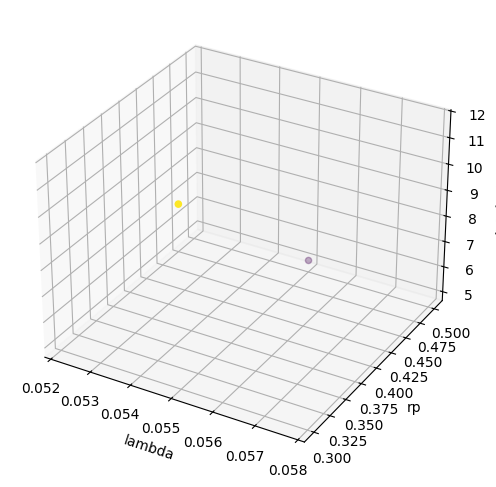

In [79]:
fixed_params = {k: 6, mu: 0.1}  # Cambia con i tuoi valori

# Convertire in funzione numerica, mantenendo k e mu fissi
dS_dt_func = sp.lambdify((t, lambda_, rp), dS_dt.subs(fixed_params), 'math')

# Funzione per trovare t numericamente
def find_t(lambda_val, rp_val):
    try:
        sol = root_scalar(lambda t: dS_dt_func(t, lambda_val, rp_val), bracket=[0.01, 30], method='brentq')
        return sol.root if sol.converged else None
    except ValueError:
        return None  # Se non trova una soluzione, restituisce None

# Creazione della tabella variando lambda e rp
lambda_vals = np.linspace(0.01, 0.1, 3)
rp_vals = np.linspace(0.1, 0.5, 3)

results = []
for lam in lambda_vals:
    for x in rp_vals:
        t_sol = find_t(lam, x)
        if t_sol is not None:
            results.append((lam, x, t_sol))

df = pd.DataFrame(results, columns=['lambda', 'rp', 't_solution'])
print(df)

# Grafico della soluzione in funzione di lambda e rp
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['lambda'], df['rp'], df['t_solution'], c=df['t_solution'], cmap='viridis')
ax.set_xlabel('lambda')
ax.set_ylabel('rp')
ax.set_zlabel('t_solution')
plt.show()

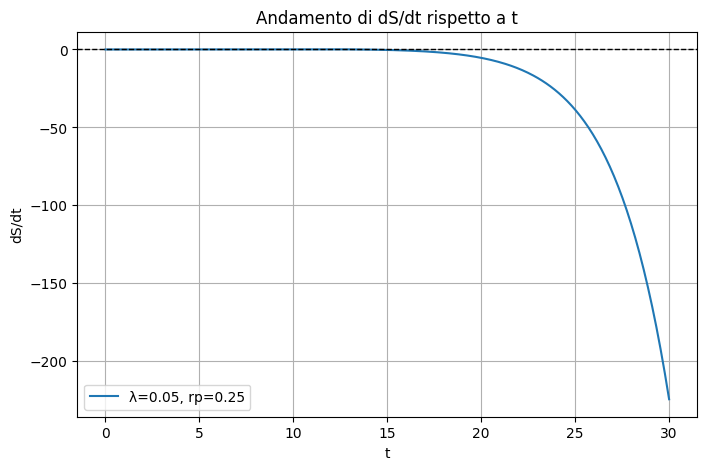

In [77]:
t_vals = np.linspace(0, 30, 400)  # Cambia l'intervallo se necessario
lambda_val = 0.05
rp_val = 0.25
dS_dt_fixed = dS_dt.subs({lambda_: lambda_val, rp: rp_val, **fixed_params})

# Convertire in funzione numerica
dS_dt_func = sp.lambdify(t, dS_dt_fixed, 'numpy')
# **Tracciare il grafico**
plt.figure(figsize=(8, 5))

t_vals = np.linspace(0, 30, 400)  # Cambia l'intervallo se necessario
dS_vals = dS_dt_func(t_vals)
plt.plot(t_vals, dS_vals, label=f"λ={lambda_val}, rp={rp_val}")
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Linea y=0
plt.xlabel("t")
plt.ylabel("dS/dt")
plt.title("Andamento di dS/dt rispetto a t")
plt.legend()
plt.grid()
plt.show()

In [73]:
dS_dt_fixed

NameError: name 'dS_dt_fixed' is not defined

In [64]:
df

,lambda,rp,t_solution
0,0.02,0.100000,3.816017
1,0.02,0.144444,2.577302
2,0.02,0.188889,1.946593
3,0.02,0.233333,1.564115
4,0.02,0.277778,1.307338
5,0.02,0.322222,1.123015
6,0.02,0.366667,0.984262
7,0.02,0.411111,0.876034
8,0.02,0.455556,0.789254
9,0.02,0.500000,0.718120


In [16]:
S_eq

Eq(0, M*N*i0*k*lambda*exp(t*(k*lambda - mu)) - N*i0*mu*(-M*i0*k*lambda*exp(t*(-mu + r_p))/(k*lambda - r_p) + M*i0*k*lambda*exp(t*(k*lambda - mu))/(k*lambda - r_p))*exp(mu*t)*exp(t*(k*lambda - mu))/(i0*exp(k*lambda*t) - i0))

In [13]:
S_eq

Eq(Derivative(S(t), t), M*N*i0*k*lambda*exp(t*(k*lambda - mu)) - N*i0*mu*(-M*i0*k*lambda*exp(t*(-mu + r_p))/(k*lambda - r_p) + M*i0*k*lambda*exp(t*(k*lambda - mu))/(k*lambda - r_p))*exp(mu*t)*exp(t*(k*lambda - mu))/(i0*exp(k*lambda*t) - i0))

In [8]:
sp.dsolve(S_eq)
#S_sol = sp.dsolve(S_eq, ics={S(0): S0})
#S_sol.simplify()

Eq((-M*N*i0*k**2*lambda**2*Integral(exp(-mu*t)*exp(-r_r*t)*exp(k*lambda*t)/(exp(k*lambda*t) - 1), t) + M*N*i0*k**2*lambda**2*Integral(exp(-mu*t)*exp(-r_r*t)*exp(2*k*lambda*t)/(exp(k*lambda*t) - 1), t) - M*N*i0*k*lambda*mu*Integral(exp(-mu*t)*exp(-r_r*t)*exp(2*k*lambda*t)/(exp(k*lambda*t) - 1), t) + M*N*i0*k*lambda*mu*Integral(exp(-mu*t)*exp(r_p*t)*exp(-r_r*t)*exp(k*lambda*t)/(exp(k*lambda*t) - 1), t) + M*N*i0*k*lambda*r_p*Integral(exp(-mu*t)*exp(-r_r*t)*exp(k*lambda*t)/(exp(k*lambda*t) - 1), t) - M*N*i0*k*lambda*r_p*Integral(exp(-mu*t)*exp(-r_r*t)*exp(2*k*lambda*t)/(exp(k*lambda*t) - 1), t) - k*lambda*r_r*Integral(S(t)*exp(-r_r*t)/(exp(k*lambda*t) - 1), t) + k*lambda*r_r*Integral(S(t)*exp(-r_r*t)*exp(k*lambda*t)/(exp(k*lambda*t) - 1), t) + r_p*r_r*Integral(S(t)*exp(-r_r*t)/(exp(k*lambda*t) - 1), t) - r_p*r_r*Integral(S(t)*exp(-r_r*t)*exp(k*lambda*t)/(exp(k*lambda*t) - 1), t))/(k*lambda - r_p), C1)

In [216]:
S_eq_approx = S_eq.subs({rr: 0})
S_sol_approx = sp.dsolve(S_eq_approx, ics={S(0): 0})

In [220]:
S_eq_approx = S_eq.subs({rr: 0}).simplify()
S_eq_approx

Eq(Derivative(S(t), t), -M*N*i0*k*lambda*(mu*(exp(t*(k*lambda - r_p)) - 1)*exp(k*lambda*t) - (k*lambda - r_p)*(exp(k*lambda*t) - 1)*exp(t*(k*lambda - r_p)))*exp(-t*(mu - r_p))/((k*lambda - r_p)*(exp(k*lambda*t) - 1)))

In [221]:
sp.solve(S_eq_approx.rhs,0)

[]

In [203]:
S_eq_approx.rhs.solve

M*N*i0*k*lambda*exp(t*(k*lambda - mu)) - N*i0*mu*(-M*i0*k*lambda*exp(t*(-mu + r_p))/(k*lambda - r_p) + M*i0*k*lambda*exp(t*(k*lambda - mu))/(k*lambda - r_p))*exp(mu*t)*exp(t*(k*lambda - mu))/(i0*exp(k*lambda*t) - i0)

In [195]:
a,b,c,d,f = sp.symbols('a,b,c,d,f', real=True)
S_prop = a  *sp.exp((b + rr)*t) + c*sp.exp((d + rr)*t) + f*sp.exp(rr*t)
S_prop_diff = sp.diff(S_prop, t)
S_eq = S_eq.subs({S(t).diff(t): S_prop_diff, S(t): S_prop})

In [196]:
S_eq

Eq(a*(b + r_r)*exp(t*(b + r_r)) + c*(d + r_r)*exp(t*(d + r_r)) + f*r_r*exp(r_r*t), M*N*i0*k*lambda*exp(t*(k*lambda - mu)) - N*i0*mu*(-M*i0*k*lambda*exp(t*(-mu + r_p))/(k*lambda - r_p) + M*i0*k*lambda*exp(t*(k*lambda - mu))/(k*lambda - r_p))*exp(mu*t)*exp(t*(k*lambda - mu))/(i0*exp(k*lambda*t) - i0) + r_r*(a*exp(t*(b + r_r)) + c*exp(t*(d + r_r)) + f*exp(r_r*t)))

In [197]:
S_eq.simplify()

Eq(a*(b + r_r)*exp(t*(b + r_r)) + c*(d + r_r)*exp(t*(d + r_r)) + f*r_r*exp(r_r*t), -(M*N*i0*k*lambda*mu*(exp(t*(k*lambda - r_p)) - 1)*exp(k*lambda*t) - (k*lambda - r_p)*(M*N*i0*k*lambda*exp(t*(k*lambda - mu)) + r_r*(a*exp(t*(b + r_r)) + c*exp(t*(d + r_r)) + f*exp(r_r*t)))*(exp(k*lambda*t) - 1)*exp(t*(mu - r_p)))*exp(-t*(mu - r_p))/((k*lambda - r_p)*(exp(k*lambda*t) - 1)))

In [198]:
S_eq = sp.expand(S_eq, sp.exp(t))
S_eq_expanded = sp.expand(S_eq)
#S_eq_0 = S_eq_expanded.subs(t, 0)
S_eq_expanded

Eq(a*b*exp(b*t)*exp(r_r*t) + a*r_r*exp(b*t)*exp(r_r*t) + c*d*exp(d*t)*exp(r_r*t) + c*r_r*exp(d*t)*exp(r_r*t) + f*r_r*exp(r_r*t), M*N*i0**2*k*lambda*mu*exp(r_p*t)*exp(k*lambda*t)/(i0*k*lambda*exp(mu*t)*exp(k*lambda*t) - i0*k*lambda*exp(mu*t) - i0*r_p*exp(mu*t)*exp(k*lambda*t) + i0*r_p*exp(mu*t)) - M*N*i0**2*k*lambda*mu*exp(2*k*lambda*t)/(i0*k*lambda*exp(mu*t)*exp(k*lambda*t) - i0*k*lambda*exp(mu*t) - i0*r_p*exp(mu*t)*exp(k*lambda*t) + i0*r_p*exp(mu*t)) + M*N*i0*k*lambda*exp(-mu*t)*exp(k*lambda*t) + a*r_r*exp(b*t)*exp(r_r*t) + c*r_r*exp(d*t)*exp(r_r*t) + f*r_r*exp(r_r*t))

In [199]:
S_eq_expanded.coeff(sp.exp(rp*t + k * lambda_ * t))

AttributeError: 'Equality' object has no attribute 'coeff'

M*N*k*lambda*i(t) - N*mu*U(t)*i(t)/C(t) + r_r*S(t)